# Exploratory Data Analysis

In [1]:
import pandas as pd

df = pd.read_excel('../data/cleaned/daily_sentences_cleaned.xlsx')
df['mo'] = df['date'].dt.month

View different frequencies of my entries

<Axes: title={'center': 'Entries by Year'}, xlabel='year'>

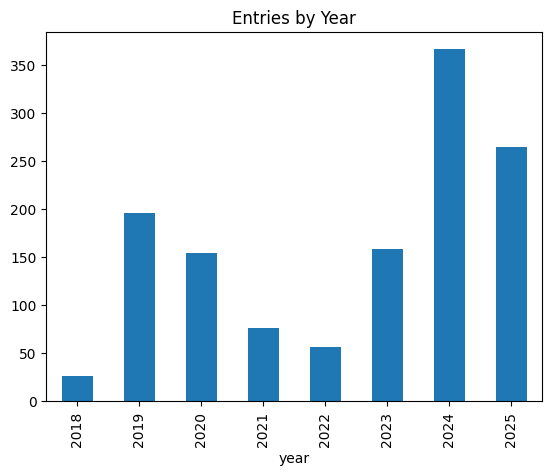

In [2]:
df.groupby(['year']).size().plot(kind='bar', title='Entries by Year')

View number of entries for each month. As you can see, I tend to write a few more entries during the summer months, then it starts to trickle down during fall/winter.
It also spikes in January when I am highly motivated!

<Axes: title={'center': 'Entries by Month'}, xlabel='mo'>

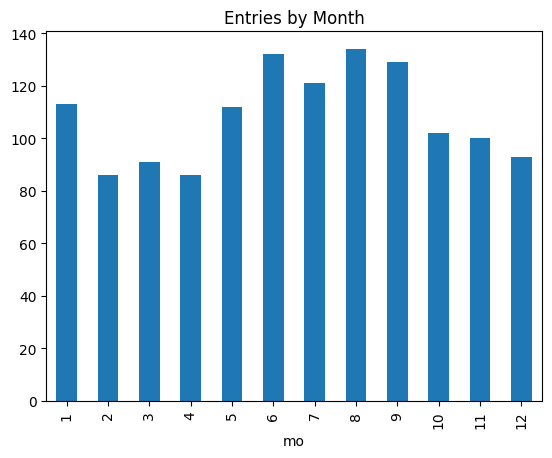

In [3]:
df.groupby(['mo']).size().plot(kind='bar', title='Entries by Month')

Displayed it for consistency but does not show much. Obviously the 31st should have half the number of records

<Axes: title={'center': 'Entries by Day of Month'}, xlabel='day'>

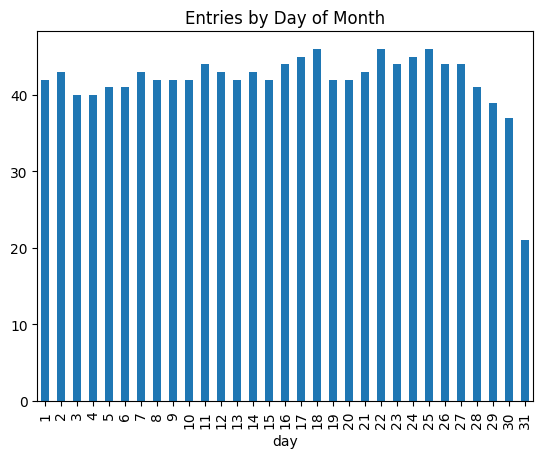

In [4]:
df.groupby(['day']).size().plot(kind='bar', title='Entries by Day of Month')

And lastly looking at the days of the week frequency. There is no bias here, I just fill them out when I remember. Actually pretty amazing the consistency here

<Axes: title={'center': 'Entries by Day of Week'}, xlabel='dayofweek'>

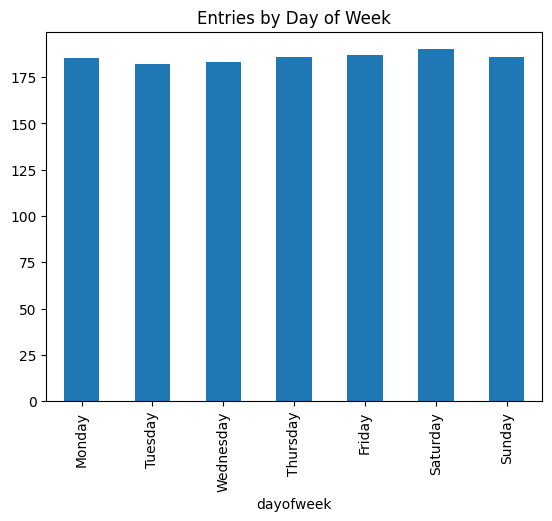

In [13]:
# 1. Extract day of week number (Monday=0, Sunday=6)
df['dayofweek_num'] = df['date'].dt.dayofweek

# 2. Map to names
df['dayofweek'] = df['dayofweek_num'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

# 3. Define the correct weekday order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 4. Make 'dayofweek' an ordered categorical
df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=order, ordered=True)

# 5. Now group and plot
(
    df.groupby('dayofweek', observed=False)
      .size()
      .reindex(order)
      .plot(kind='bar', title='Entries by Day of Week')
)


## Statistics
For each entry, it would be interesting to see the number of characters and the number of words as an average.
Grouping by each year, I have pretty consistently written more in my journal, but around 2022 it's around the same.

Average character count per entry: 84.14
Average word count per entry: 15.29


<Axes: title={'center': 'Average Word Count per Year'}, xlabel='year'>

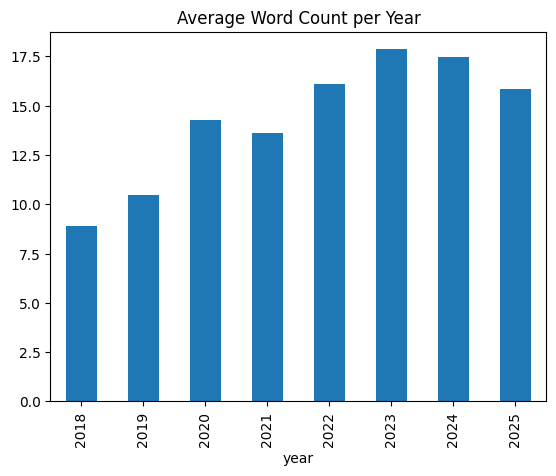

In [15]:
avg_char_count = df['sentence'].str.len().mean()
print('Average character count per entry:', round(avg_char_count, 2))

avg_word_count = df["sentence"].str.split().str.len().mean()
print('Average word count per entry:', round(avg_word_count, 2))

df.groupby(['year'])['sentence'].apply(lambda x: x.str.split().str.len().mean()).plot(kind='bar', title='Average Word Count per Year')

Next up is coverage - seeing how often I actually fill out my journal out of the possible days.
Overall, I fill it out almost 50% of the time, but the past 2 years I have done much better!

In [16]:
start_date = df['date'].min()
end_date = df['date'].max()
total_days = (end_date - start_date).days + 1
total_entries = df.shape[0]
percentage_filled = (total_entries / total_days) * 100
print(f"Percentage of days with entries: {percentage_filled:.2f}%")

# Function to compute year coverage
def year_coverage(df):
    coverage = []
    for year, group in df.groupby('year'):
        start = pd.Timestamp(year=year, month=1, day=1)
        end = pd.Timestamp(year=year, month=12, day=31)

        # Clamp to your overall range
        start = max(start, start_date)
        end = min(end, end_date)

        total_days = (end - start).days + 1
        actual_days = group['date'].nunique()
        percent = (actual_days / total_days) * 100
        coverage.append({'year': year, 'Days Logged': actual_days,
                         'Possible Days': total_days, 'Coverage %': round(percent, 2)})
    return pd.DataFrame(coverage)

coverage_df = year_coverage(df)
print(coverage_df)

Percentage of days with entries: 48.49%
   year  Days Logged  Possible Days  Coverage %
0  2018           26            208       12.50
1  2019          196            365       53.70
2  2020          154            366       42.08
3  2021           76            365       20.82
4  2022           57            365       15.62
5  2023          159            365       43.56
6  2024          366            366      100.00
7  2025          265            279       94.98


Let's visualize this

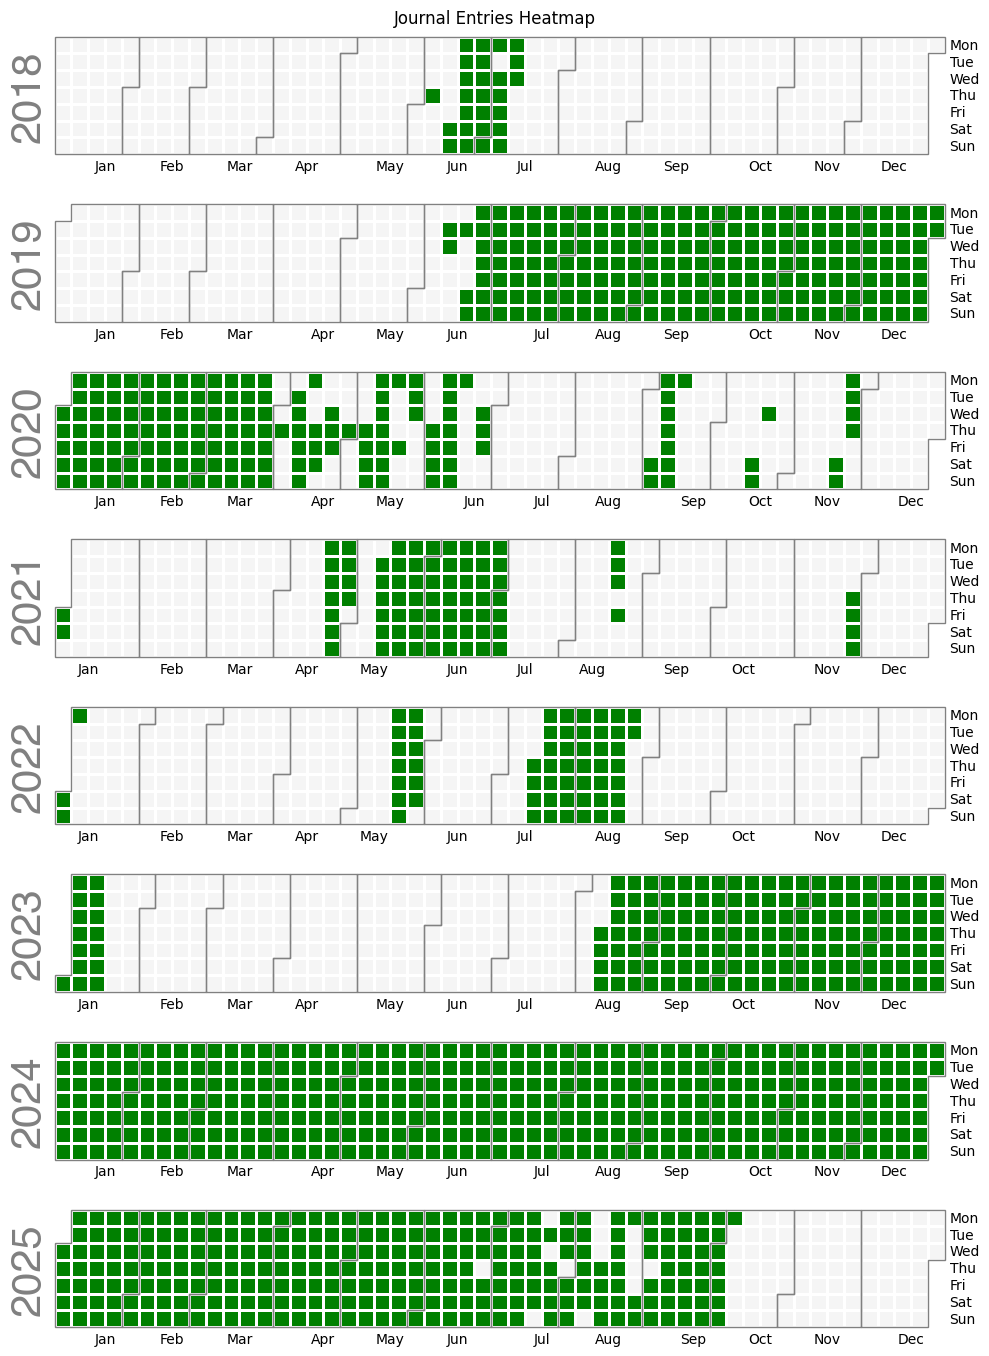

In [18]:
import calplot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

daily = df.groupby('date').size()  # counts per day
daily = daily.reindex(pd.date_range(df['date'].min(), df['date'].max()), fill_value=0)
binary_daily = daily.copy()
binary_daily[binary_daily > 0] = 1 

cmap = ListedColormap(['lightgrey', 'green'])  # 0=missing, 1=written
calplot.calplot(
    binary_daily,
    cmap=cmap,
    vmin=0,
    vmax=1,
    suptitle='Journal Entries Heatmap',
    colorbar=False
)
plt.show()

Correlation between number of words per entry and frequency of records. Not a strong correlation but trying to see if I am putting longer records in, then am I more likely to keep adding records.

        date  entries  avg_word_count
0 2018-06-30       16            10.5
1 2018-07-31       10             6.3
2 2018-08-31        0             NaN
3 2018-09-30        0             NaN
4 2018-10-31        0             NaN
Correlation: 0.25974442758640137


Text(0.5, 1.0, 'Journal Activity Over Time')

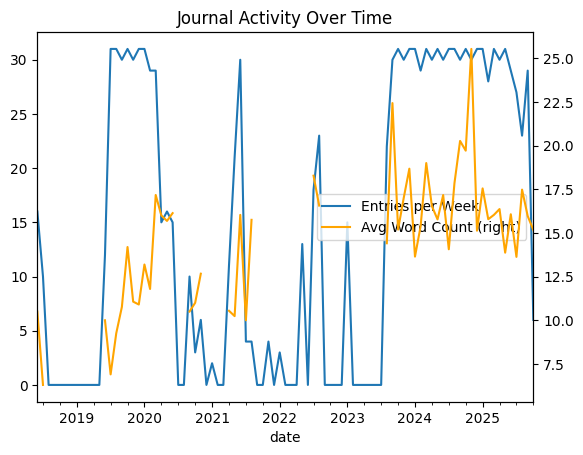

In [25]:
df['word_count'] = df['sentence'].str.split().str.len()

weekly = (
    df.groupby(pd.Grouper(key='date', freq='ME'))
      .agg(
          entries=('sentence', 'count'),
          avg_word_count=('word_count', 'mean')
      )
      .reset_index()
)
print(weekly.head())    

corr = weekly['entries'].corr(weekly['avg_word_count'])
print("Correlation:", corr)

ax = weekly.plot(x='date', y='entries', label='Entries per Week')
weekly.plot(x='date', y='avg_word_count', secondary_y=True, ax=ax, label='Avg Word Count', color='orange')
ax.set_title('Journal Activity Over Time')